In [1]:
import openai
import pandas as pd
import numpy as np
import math
import tqdm

from sklearn.metrics import f1_score, accuracy_score, precision_score


In [2]:
!pip3 install openai

DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/avgn-0.1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


# Are informal comments more toxic?

In this notebook we'll use Marianna Apidianaki's method of calculating interpretable dimensions in semantic vector space on the fly using seed pairs. To start, we want to look at the same dimensions: formality and complexity. But we want to look at the sentence level rather than the word level. 

## Step 1: Generating formality seed pairs

We want sevenish pairs of sentences, or really two symmetrical groups of sentences, that can be used to calculate a dimension. 

In [3]:
sentences = """Last week I got into a car accident.
She had some amazing news to share but nobody to share it with.
Sometime you just have to give up and win by cheating.
They desperately needed another drummer since the current one only knew how to play bongos.
The bread dough reminded her of Santa Clause’s belly.
He realized there had been several deaths on this road, but his concern rose when he saw the exact number.
Trash covered the landscape like sprinkles do a birthday cake."""
sentences = sentences.split("\n")
sentences

['Last week I got into a car accident.',
 'She had some amazing news to share but nobody to share it with.',
 'Sometime you just have to give up and win by cheating.',
 'They desperately needed another drummer since the current one only knew how to play bongos.',
 'The bread dough reminded her of Santa Clause’s belly.',
 'He realized there had been several deaths on this road, but his concern rose when he saw the exact number.',
 'Trash covered the landscape like sprinkles do a birthday cake.']

### Step 1: Load and use GPT to generate sentences

In [4]:
from openai import OpenAI
client = OpenAI() # OPENAI_API_KEY environment variable must be set. see quickstart tutorial here: https://platform.openai.com/docs/quickstart?context=python



Try an example completion

In [5]:
sentence = sentences[0]

messages=[
    {"role": "system", "content": "You are a rewording assistant, skilled in transforming a statement to express more or less of a given quality or property."},
    {"role": "user", "content": "Rephrase the following statement to use language that is more complex: \"{}\" .".format(sentence)}
  ]


In [6]:
completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=messages
)

print(completion.choices[0].message)

ChatCompletionMessage(content='During the preceding week, I was involved in a vehicular collision.', role='assistant', function_call=None, tool_calls=None)


In [7]:
completion.choices[0]

Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='During the preceding week, I was involved in a vehicular collision.', role='assistant', function_call=None, tool_calls=None))

We'll feed this output back to the api 

In [8]:
messages.append({'role': 'system', 'content': completion.choices[0].message.content})
messages.append({"role": "user", "content": "Good. Rephrase the sentence again to use language that is even more complex."})
messages

[{'role': 'system',
  'content': 'You are a rewording assistant, skilled in transforming a statement to express more or less of a given quality or property.'},
 {'role': 'user',
  'content': 'Rephrase the following statement to use language that is more complex: "Last week I got into a car accident." .'},
 {'role': 'system',
  'content': 'During the preceding week, I was involved in a vehicular collision.'},
 {'role': 'user',
  'content': 'Good. Rephrase the sentence again to use language that is even more complex.'}]

In [9]:
def complete(messages):
    completion = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=messages,
      seed=42
    )
    return completion.choices[0].message.content

complete(messages)

'In the course of the antecedent week, I found myself implicated in an unfortunate incident of a vehicular nature, resulting in a collision.'

### prompt templates

In [10]:
# dictionary of the adjectives we use (property adjective and antonym) to create prompts

property_dict = {
    'complexity':   ('complex', 'simple'),
    'emotion':      ('emotional', 'emotionless')
}


We will generate sentences from a series of templates. For each sentence, we want to generate 'more x', 'even more x', as well as 'less x' and 'even less x'. Because the model often produces longer sentences for 'more' prompts, we also prompt for rephrasings using an antonymous adjective. So, for example, we ask for rephrasings that are "more complex" as well as rephrasings that are "less simple". We then use all of these rephrasings to calculate the complexity dimension.

In [11]:
# TODO save 5 responses instead of 1


adj, antonym = property_dict['complexity']

data = []

for sent in sentences:

    for i, x in enumerate([adj, antonym]):
        print(i)
        print(x)
        messages=[
            {"role": "system", "content": "You are a rewording assistant, skilled in transforming a statement to express more or less of a given quality or property. The new statement should be the same length."},
        ]

        
        # more
        more_messages = messages + [{"role": "user", "content": "Rephrase the following statement to use language that is more {}. The new statement should be the same length: \"{}\" .".format(x,sent)}]
        more = complete(more_messages)
        print(more)
        
        # less
        less_messages = messages + [{"role": "user", "content": "Rephrase the following statement to use language that is less {}. The new statement should be the same length: \"{}\" .".format(x,sent)}]
        less = complete(less_messages)
        print(less)
        
        row = {
             'sentence': sent,
             'text1': more,
             'text2': less,
             'low': less if i==0 else more,
             'high': more if i==0 else less,
             'more': 1,
             'even_more': 0,
             'less': 1,
             'even_less':  0,
             'property': 'complexity',
             'adjective': x,
             'antonym?': 0 if i == 0 else 1 # the second in the pair is the antonym
        }
        data.append(row)
                
        # even more
        even_more_messages = more_messages + [{"role": "system", "content": more}] + [{"role": "user", "content": "Good. Rephrase the sentence again to use language that is even more {}. The new statement should be the same length.".format(x)}]
        even_more = complete(even_more_messages)
        print(even_more)
        
        # even less
        even_less_messages = less_messages + [{"role": "system", "content": less}] + [{"role": "user", "content": "Good. Rephrase the sentence again to use language that is even less {}. The new statement should be the same length.".format(x)}]
        even_less = complete(even_less_messages)
        print(even_less)
        
        row = {
             'sentence': sent,
             'text1': even_more,
             'text2': even_less,
             'low': even_less if i==0 else even_more, #switches on the antonym
             'high': even_more if i==0 else even_less,
             'more': 0,
             'even_more': 1,
             'less': 0,
             'even_less':  1,
             'property': 'complexity',
             'adjective': x,
             'antonym?': 0 if i == 0 else 1 # the second in the pair is the antonym
        }
        data.append(row)

        # TODO even even more


    
df = pd.DataFrame.from_records(data)
df

0
complex
During the preceding week, I was involved in a motor vehicle collision.
I had a car crash last week.
In the course of the previous week, I found myself entangled in an unfortunate circumstance which resulted in a collision between my motor vehicle and another.
I crashed my car last week.
1
simple
I had a car crash last week.
I experienced a vehicular collision last week.
I crashed my car last week.
Last week, an unfortunate incident transpired wherein a collision involving an automobile occurred.
0
complex
She possessed momentous tidings to disseminate, however, she lacked individuals with whom to disseminate them.
She had great news to tell, but no one to tell it to.
She was in possession of astounding news, the kind that was capable of leaving one in awe, yet she found herself lacking the presence of suitable individuals with whom she could wholeheartedly disclose and relay this remarkable information.
She had good news, but no one to share it with.
1
simple
She had great n

,sentence,text1,text2,low,high,more,even_more,less,even_less,property,adjective,antonym?
0,Last week I got into a car accident.,"During the preceding week, I was involved in a...",I had a car crash last week.,I had a car crash last week.,"During the preceding week, I was involved in a...",1,0,1,0,complexity,complex,0
1,Last week I got into a car accident.,"In the course of the previous week, I found my...",I crashed my car last week.,I crashed my car last week.,"In the course of the previous week, I found my...",0,1,0,1,complexity,complex,0
2,Last week I got into a car accident.,I had a car crash last week.,I experienced a vehicular collision last week.,I had a car crash last week.,I experienced a vehicular collision last week.,1,0,1,0,complexity,simple,1
3,Last week I got into a car accident.,I crashed my car last week.,"Last week, an unfortunate incident transpired ...",I crashed my car last week.,"Last week, an unfortunate incident transpired ...",0,1,0,1,complexity,simple,1
4,She had some amazing news to share but nobody ...,She possessed momentous tidings to disseminate...,"She had great news to tell, but no one to tell...","She had great news to tell, but no one to tell...",She possessed momentous tidings to disseminate...,1,0,1,0,complexity,complex,0
5,She had some amazing news to share but nobody ...,"She was in possession of astounding news, the ...","She had good news, but no one to share it with.","She had good news, but no one to share it with.","She was in possession of astounding news, the ...",0,1,0,1,complexity,complex,0
6,She had some amazing news to share but nobody ...,"She had great news to tell, but no one to tell...",She possessed momentous tidings to disseminate...,"She had great news to tell, but no one to tell...",She possessed momentous tidings to disseminate...,1,0,1,0,complexity,simple,1
7,She had some amazing news to share but nobody ...,"She had good news, but no one to share it with.",She was in possession of extraordinary news to...,"She had good news, but no one to share it with.",She was in possession of extraordinary news to...,0,1,0,1,complexity,simple,1
8,Sometime you just have to give up and win by c...,"At certain points in life, it becomes necessar...",Sometimes you have to cheat to win.,Sometimes you have to cheat to win.,"At certain points in life, it becomes necessar...",1,0,1,0,complexity,complex,0
9,Sometime you just have to give up and win by c...,At certain junctures in the intricate tapestry...,You have to cheat to win sometimes.,You have to cheat to win sometimes.,At certain junctures in the intricate tapestry...,0,1,0,1,complexity,complex,0


Save so we don't have to query the api every time

In [12]:
df.to_csv('make_it_more_complexity_pilot_seed_sentences.csv')

## Step 2: Calculating the formality dimension



In [13]:
df = pd.read_csv('make_it_more_complexity_pilot_seed_sentences.csv')

Now that we have our seed sentences for the complexity dimension, we need to get the vector differences for the seed pairs.

We generated 8 sentences for each original seed sentence, meaning we have four seed pairs.

The formulas for the four seed pairs are as follows:

- ( adjective + more ) - (adjective + less)
- ( adjective + even more ) - (adjective + even less)
- ( antonym + less ) - (antonym + more )
- ( antonym + even less ) - (antonym + even more )

First we get an embedding for both complementary sentences in each row (text1 and text2). Then, for each seed sentence we calculate these four formulae to get the vector differences. And then we average those together. 

In [14]:
df.head(5)

,Unnamed: 0,sentence,text1,text2,low,high,more,even_more,less,even_less,property,adjective,antonym?
0,0,Last week I got into a car accident.,"During the preceding week, I was involved in a...",I had a car crash last week.,I had a car crash last week.,"During the preceding week, I was involved in a...",1,0,1,0,complexity,complex,0
1,1,Last week I got into a car accident.,"In the course of the previous week, I found my...",I crashed my car last week.,I crashed my car last week.,"In the course of the previous week, I found my...",0,1,0,1,complexity,complex,0
2,2,Last week I got into a car accident.,I had a car crash last week.,I experienced a vehicular collision last week.,I had a car crash last week.,I experienced a vehicular collision last week.,1,0,1,0,complexity,simple,1
3,3,Last week I got into a car accident.,I crashed my car last week.,"Last week, an unfortunate incident transpired ...",I crashed my car last week.,"Last week, an unfortunate incident transpired ...",0,1,0,1,complexity,simple,1
4,4,She had some amazing news to share but nobody ...,She possessed momentous tidings to disseminate...,"She had great news to tell, but no one to tell...","She had great news to tell, but no one to tell...",She possessed momentous tidings to disseminate...,1,0,1,0,complexity,complex,0


~~NOPE__So now that we have our seed sentences for the complexity dimension, we need to split them into negative and positive sentences. The generated sentences should be divided as follows.~~

~~Positive
- adjective + more
- adjective + even more
- antonym + less
- antonym + even less

Negative
- adjective + less
- adjective + even less
- antonym + more
- antonym + even more

~~After we split them into positive and negative examples, we embed them using SBERT~~

Obviously we run into the problem where typically vectors are word or token-level and we want sentence-level representations. The absolute simplest thing I can think of to do here is to use SentenceBERT, which we will download from huggingface.

After initializing the model, we generate vector representations for each sentence in the informal list and for each corresponding sentence in the formal list. We subtract the vectors from one another and then take the average, leaving us with a vector that represents the formality dimension. We can rate any sentence vector(s) on the formality dimension by giving them (as a list) to the function predict_scalarproj along with the dimension itself. 

In [15]:
# load sbert
!pip install -U sentence-transformers

DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/avgn-0.1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [16]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

low = df['low'].to_list()
high = df['high'].to_list()

#Sentences are encoded by calling model.encode()
embeddings1 = model.encode(low)
embeddings2 = model.encode(high)


#df = df.assign(embedding1=embeddings1.tolist())
#df = df.assign(embedding2=embeddings2.tolist())


df.head(5)

# #Print the embeddings
# for sentence, embedding in zip(positive[:5], pos_embeddings[:5]):
#     print("Sentence:", sentence)
#     print("Embedding:", embedding[:100])
#     print("")

,Unnamed: 0,sentence,text1,text2,low,high,more,even_more,less,even_less,property,adjective,antonym?
0,0,Last week I got into a car accident.,"During the preceding week, I was involved in a...",I had a car crash last week.,I had a car crash last week.,"During the preceding week, I was involved in a...",1,0,1,0,complexity,complex,0
1,1,Last week I got into a car accident.,"In the course of the previous week, I found my...",I crashed my car last week.,I crashed my car last week.,"In the course of the previous week, I found my...",0,1,0,1,complexity,complex,0
2,2,Last week I got into a car accident.,I had a car crash last week.,I experienced a vehicular collision last week.,I had a car crash last week.,I experienced a vehicular collision last week.,1,0,1,0,complexity,simple,1
3,3,Last week I got into a car accident.,I crashed my car last week.,"Last week, an unfortunate incident transpired ...",I crashed my car last week.,"Last week, an unfortunate incident transpired ...",0,1,0,1,complexity,simple,1
4,4,She had some amazing news to share but nobody ...,She possessed momentous tidings to disseminate...,"She had great news to tell, but no one to tell...","She had great news to tell, but no one to tell...",She possessed momentous tidings to disseminate...,1,0,1,0,complexity,complex,0


In [17]:
difference_vecs = (embeddings2 - embeddings1)

In [18]:
dimvec = np.mean(difference_vecs, axis = 0)
dimvec

array([ 2.80994177e-03,  2.43494380e-02, -5.53387310e-03,  1.30705209e-02,
       -3.44142527e-03,  5.47638256e-03,  1.93053391e-02, -4.64231241e-03,
       -1.55945197e-02,  4.28219850e-04,  1.66551359e-02, -3.14039877e-03,
        7.73083419e-03,  1.28244609e-02,  7.15374574e-03, -3.51320929e-03,
        2.32063103e-02,  5.23556629e-03,  8.71132535e-04,  2.89073978e-02,
        1.07601983e-02,  2.72600773e-05, -1.35922823e-02, -3.08729545e-03,
       -1.65573619e-02,  1.12537798e-02, -1.44880346e-03, -2.18065400e-02,
        4.17778902e-02, -9.35622025e-03,  7.32538942e-03,  1.43189803e-02,
       -1.62199966e-03,  2.46962663e-02,  1.18385209e-02,  3.68743800e-02,
        7.98771996e-03, -2.24662735e-03,  5.93581377e-03, -1.67097282e-02,
       -3.32519831e-03, -9.60902683e-03, -2.20325198e-02, -4.46266169e-03,
       -1.46324700e-02, -8.73265136e-03, -9.93020274e-03,  2.83677969e-02,
       -5.85328303e-02, -1.33099798e-02, -1.51768243e-02, -9.46997106e-03,
       -3.51107540e-03,  

In [19]:
#### from marianna + katrin
# seed-based method
# averaging over seed pair vectors
# def dimension_seedbased(seeds_pos, seeds_neg, space, paired = False):
#     diffvectors = [ ]
    
#     for negword, posword in _make_seedpairs(seeds_pos, seeds_neg, paired = paired):
#         diffvectors.append(space[posword] - space[negword])

#     # average
#     dimvec = np.mean(diffvectors, axis = 0)
#     return dimvec


In [20]:
def dimension_seedbased():
    return dimvec

In [21]:
complexity_dimension = dimension_seedbased()

In [22]:
# vector scalar projection (from marianna + katrin)
def predict_scalarproj(veclist, dimension):
    dir_veclen = math.sqrt(np.dot(dimension, dimension))
    return [np.dot(v, dimension) / dir_veclen for v in veclist]

# Step 2.5 Debugging the Formality Dimension

Initial validation on Simple PPDB (Step 3 below) was not very good (read: very bad). We got 43% accuracy predicting which of two words/phrases was simpler, meaning: if we'd done nothing at all, the world would be a better place. 

So, there are four possibilities in order of increasing severity.

1) we ran the validation experiment wrong
2) we calculated the complexity dimension wrong
3) we did everything right (i.e. no bugs) but are seeing this result because the validation dataset is out of domain (model and complexity dimension are for sentences; the dataset is just words and phrases).
4) we did everything right (i.e. no bugs) and the dimension is just not helpful at all in predicting complexity

We can rule out 2 by checking that the seed pairs we used to calculate the dimension in fact line up the way they should.

In [23]:
golds = []
for i, row in df.iterrows():
    
    gold = row["text1"] if (row["adjective"] == "simple") else row["text2"]
    golds.append(gold)
    print(row["text1"])
    print(row["text2"])
    print(gold)
    print()
    


During the preceding week, I was involved in a motor vehicle collision.
I had a car crash last week.
I had a car crash last week.

In the course of the previous week, I found myself entangled in an unfortunate circumstance which resulted in a collision between my motor vehicle and another.
I crashed my car last week.
I crashed my car last week.

I had a car crash last week.
I experienced a vehicular collision last week.
I had a car crash last week.

I crashed my car last week.
Last week, an unfortunate incident transpired wherein a collision involving an automobile occurred.
I crashed my car last week.

She possessed momentous tidings to disseminate, however, she lacked individuals with whom to disseminate them.
She had great news to tell, but no one to tell it to.
She had great news to tell, but no one to tell it to.

She was in possession of astounding news, the kind that was capable of leaving one in awe, yet she found herself lacking the presence of suitable individuals with whom s

In [24]:
predictions = []

for i, row in df.iterrows():
    left = model.encode(row["text1"])
    right = model.encode(row["text2"])
    preds = predict_scalarproj([left,right], dimvec)
    simple_pred = np.argmin(preds)

    # text1 is simpler if we used the "more complex" prompt
    
    if simple_pred == 0: # we predict the 'more simple text' as simpler
        simplest_word = row["text1"]
    else:
        simplest_word = row["text2"]

    # print(golds[i])
    # print(simplest_word)
    # print()
    predictions.append(simplest_word)

In [25]:
# accuracy
acc = accuracy_score(golds, predictions)
print(acc)



# this is binary but rather than compute the binary just pretend we have a million labels and take the macro average
f1 = f1_score(golds, predictions, average="macro")
print(f1)

1.0
1.0


The dimension is extremely inaccurate even on the seed sentences used to create it. So, something is wrong with how we have created it. Let's figure out how to debug it. 

# Step 3: validating the formality dimension

does it behave the same way as a standard classifier?


We load a regular classifier

We run this prediction method and the formality classifier on the formality dataset. 

We compare. Is the dimension-based method that much worse?

We load a complexity dataset - perhaps the word-based one that Marianna uses.

We order the entries by their complexity rating and look at where they fall on our complexity axis.

We are going to use Simple PPDB

In [26]:
!pip3 install openpyxl

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/avgn-0.1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [27]:
simple_ppdb = pd.read_csv('~/Downloads/SimplePPDB/human-labeled-data/training-pairs', delimiter="\t")
simple_ppdb

,majority,total,x,y,gold
0,6,7,the wrath,rage,"turkers=""rage"""
1,6,7,toys,playthings,"turkers=""toys"""
2,5,7,proposed,are offering,"turkers=""are offering"""
3,7,7,farther,even further,"turkers=""farther"""
4,4,7,our youth,adolescents,"turkers=""our youth"""
...,...,...,...,...,...
3752,5,7,the stress,tensions,"turkers=""the stress"""
3753,4,7,households,canadian households,"turkers=""households"""
3754,4,7,saintly,sacred,"turkers=""NA"""
3755,6,7,fuss,bullshit,"turkers=""fuss"""


limit to rows with majority 5 or more out of seven, and clean up the row with the simplification

In [28]:
def text_between_quotes(text):
    return text.split('"')[1::2][0]
    
simple_ppdb = simple_ppdb[simple_ppdb['majority']/simple_ppdb['total'] >= 5/7 ]

len(simple_ppdb)

1915

In [29]:
golds = []
for i,row in simple_ppdb.iterrows():

    gold = text_between_quotes(row.gold)
    #print(gold)
    golds.append(gold)

print(len(golds))

simple_ppdb['gold'] = golds

simple_ppdb

1915


/var/folders/9m/vzvx58rs51v_x5nm620fz4xr0000gn/T/ipykernel_66810/3137916988.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simple_ppdb['gold'] = golds


,majority,total,x,y,gold
0,6,7,the wrath,rage,rage
1,6,7,toys,playthings,toys
2,5,7,proposed,are offering,are offering
3,7,7,farther,even further,farther
5,5,7,upper,high-end,upper
...,...,...,...,...,...
3747,6,7,farmland,agro-industrial,farmland
3749,6,7,finishing,are done,are done
3750,6,7,cartons,canisters,cartons
3752,5,7,the stress,tensions,the stress


you want to add one column to this data: "predicted". you want to add a coolumn with the word predicted to be simpler.

So you need a function that predicts complexity values for both word and returns the word with the lower predicted value on the complexity dimension.

In [30]:
predictions = []

for i, row in simple_ppdb.iterrows():
    left = model.encode(row["x"])
    right = model.encode(row["y"])
    preds = predict_scalarproj([left,right], dimvec)
    simple_pred = np.argmin(preds)
    if simple_pred == 0:
        simplest_word = row["x"]
    else:
        simplest_word = row["y"]

    # print(row["gold"])
    # print(simplest_word)
    predictions.append(simplest_word)

In [31]:
simple_ppdb['prediction'] = predictions

simple_ppdb['correct'] = np.where(simple_ppdb['prediction']== simple_ppdb['gold'], True, False)

#simple_ppdb['correct?'] = simple_ppdb[simple_ppdb['prediction'] == simple_ppdb['gold']]

simple_ppdb.head(5)

/var/folders/9m/vzvx58rs51v_x5nm620fz4xr0000gn/T/ipykernel_66810/1040636533.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simple_ppdb['prediction'] = predictions
/var/folders/9m/vzvx58rs51v_x5nm620fz4xr0000gn/T/ipykernel_66810/1040636533.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simple_ppdb['correct'] = np.where(simple_ppdb['prediction']== simple_ppdb['gold'], True, False)


,majority,total,x,y,gold,prediction,correct
0,6,7,the wrath,rage,rage,rage,True
1,6,7,toys,playthings,toys,toys,True
2,5,7,proposed,are offering,are offering,proposed,False
3,7,7,farther,even further,farther,farther,True
5,5,7,upper,high-end,upper,high-end,False


Now that we have predicted the simplest word using our calculated complexity dimension, we measure how well the complexity dimension aligns with human judgments (keeping in mind that we have just sbertized single words and phrases so that could potentially be a little funky.

In [32]:
#accuracy
print(simple_ppdb['correct'].value_counts())

print(1279 / (1279 + 636))

# accuracy
acc = accuracy_score(simple_ppdb["gold"], predictions)
print(acc)

# precision
prec = precision_score(simple_ppdb["gold"], predictions, average="macro")
print(prec)

# this is binary but rather than compute the binary just pretend we have a million labels and take the macro average
f1 = f1_score( simple_ppdb["gold"], predictions, average="macro")
print(f1)

correct
True     1274
False     641
Name: count, dtype: int64
0.6678851174934726
0.6652741514360313
0.5017552182163187
0.4864166826216162


/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
# precision

## Step 4: Rating Toxicity Datasets for complexity

We'll start with the 1000-length parallel dataset from the text detoxification paper. 

We load it in

We SBERTize the sentences

We pass them to the prediction method. 

We observe: do toxic and nontoxic comments differ wrt formality?

In [34]:
!pip install datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/avgn-0.1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [4]:
from datasets import load_dataset

dataset = load_dataset("civil_comments")

Found cached dataset parquet (/Users/gabriellachronis/.cache/huggingface/datasets/parquet/civil_comments-e92c9358c47debf9/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/3 [00:00<?, ?it/s]

In [36]:
dataset["train"][0]

{'text': "This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",
 'toxicity': 0.0,
 'severe_toxicity': 0.0,
 'obscene': 0.0,
 'threat': 0.0,
 'insult': 0.0,
 'identity_attack': 0.0,
 'sexual_explicit': 0.0}

In [37]:
dataset["train"][:10]['text']

["This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",
 "Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",
 'This is such an urgent design problem; kudos to you for taking it on. Very impressive!',
 "Is this something I'll be able to install on my site? When will you be releasing it?",
 'haha you guys are a bunch of losers.',
 'ur a sh*tty comment.',
 'hahahahahahahahhha suck it.',
 'FFFFUUUUUUUUUUUUUUU',
 'The ranchers seem motivated by mostly by greed; no one should have the right to allow their animals destroy public land.',
 "It was a great show. Not a combo I'd of expected to be good together but it was."]

In [38]:
###################################
#########
# predicting ratings on a dimension

# ...
# when we only have the dimension:
# vector scalar projection
def predict_scalarproj(veclist, dimension):
    dir_veclen = math.sqrt(np.dot(dimension, dimension))
    return [np.dot(v, dimension) / dir_veclen for v in veclist]

SBERtize the Comments

In [39]:
sentence_embs = [model.encode(row) for row in dataset["train"][:1000]['text']]


Calculate complexity 

In [40]:
complexities = predict_scalarproj(sentence_embs, dimvec)

# for i, emb in enumerate(sentence_embs):
#     dataset["train"][i]['complexity_computed'] = sentence_embs[i]
#     complexities.append( sentence_embs[i] )

#dataset["train"][:5]
complexities[:5]

[-0.02702487891452554,
 -0.04039088421792207,
 0.09361892816634214,
 0.010779758339817948,
 -0.1743443996307032]

Retrieve gold toxicity score

In [41]:
toxicity_scores = dataset["train"][:1000]['toxicity']

In [42]:
dataset["train"][:10]['text']

["This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",
 "Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",
 'This is such an urgent design problem; kudos to you for taking it on. Very impressive!',
 "Is this something I'll be able to install on my site? When will you be releasing it?",
 'haha you guys are a bunch of losers.',
 'ur a sh*tty comment.',
 'hahahahahahahahhha suck it.',
 'FFFFUUUUUUUUUUUUUUU',
 'The ranchers seem motivated by mostly by greed; no one should have the right to allow their animals destroy public land.',
 "It was a great show. Not a combo I'd of expected to be good together but it was."]

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

Text(0, 0.5, 'toxicity')

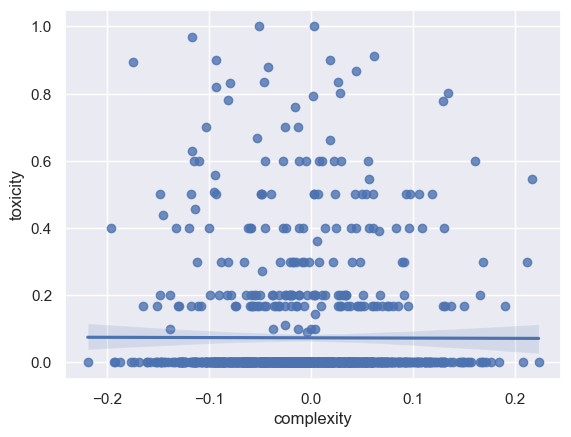

In [44]:
sns.regplot(x=complexities, y=toxicity_scores)
plt.xlabel("complexity")
plt.ylabel("toxicity")

In [45]:
import numpy as np
import scipy.stats

scipy.stats.pearsonr(complexities, toxicity_scores)    # Pearson's r

PearsonRResult(statistic=-0.0031172255260162383, pvalue=0.9215731663888542)

Complexity and toxicity are negatively correlated, as predicted. As complexity increases, toxicity decreases. 

In [5]:
sentences = dataset["train"][:1000]['text']

toxicity_analysis = pd.DataFrame()
toxicity_analysis['sentence'] = sentences
toxicity_analysis['toxicity'] = toxicity_scores
toxicity_analysis['predicted_complexity'] = complexities


NameError: name 'pd' is not defined

In [2]:
# print most emotional
toxicity_analysis.sort_values(by="predicted_emotionality").head(25)

NameError: name 'toxicity_analysis' is not defined